# [$R^1$] Re-Runnable
##### Last Updated: October 2022


## Introduction: <sup>[1]</sup>
Have you ever tried to re-run a program you wrote some years ago? It can often be frustratingly hard. Part of the problem is that technology is evolving at a fast pace and you cannot know in advance how the system, the software and the libraries your program depends on will evolve. Since you wrote the code, you may have reinstalled or upgraded your operating system. The compiler, interpreter or set of libraries installed may have been replaced with newer versions. You may find yourself battling with arcane issues of library compatibility—thoroughly orthogonal to your immediate research goals—to execute again a code that worked perfectly before. To be clear, it is impossible to write future-proof code, and the best efforts can be stymied by the smallest change in one of the dependencies. At the same time, modernizing an unmaintained ten-year-old code can reveal itself to be an arduous and expensive undertaking—and precarious, since each change risks affecting the semantics of the program. Rather than trying to predict the future or painstakingly dusting off old code, an often more straightforward solution is to recreate the old execution environment. For this to happen however, the dependencies in terms of systems, software, and libraries must be made clear enough.

A re-runnable code is one that can be run again when needed, and in particular more than the one time that was needed to produce the results. It is important to notice that the re-runnability of a code is not an intrinsic property. Rather, it depends on the context, and becomes increasingly difficult as the code ages. Therefore, to be and remain re-runnable on the computers of other researchers, a re-runnable code should describe—with enough details to be recreated—an execution environment in which it is executable. As shown by Collberg and Proebsting (2016), this is far from being either obvious or easy.

## Solution:

In this project, we use Docker to recreate the execution environment that have been previously used to build, test, and run the refactored and translated code for this successful replication study. Docker is a common industry-wide choice to package and run applications in light-weight containers that are configured independently from the host machine. These containers are created from a customized Docker image that can be consistently rebuilt using `Dockerfile` provided in the codebase. For the `docker build` command to successfully run, we require all users to specify the value of build argument `mode`.

Under `mode = replication` where the Python source code lives, we observe the following specifications: 

### Operating System Specs:

In [2]:
! cat /etc/os-release

PRETTY_NAME="Debian GNU/Linux 11 (bullseye)"
NAME="Debian GNU/Linux"
VERSION_ID="11"
VERSION="11 (bullseye)"
VERSION_CODENAME=bullseye
ID=debian
HOME_URL="https://www.debian.org/"
SUPPORT_URL="https://www.debian.org/support"
BUG_REPORT_URL="https://bugs.debian.org/"


### Python Interpreter:

In [3]:
! python --version

Python 3.7.15


### Versioning of Python Libraries:

In [4]:
! cut -d'>' -f1 ../requirements.txt | xargs pip show

Name: cvxpy
Version: 1.2.1
Summary: A domain-specific language for modeling convex optimization problems in Python.
Home-page: https://github.com/cvxpy/cvxpy
Author: Steven Diamond, Eric Chu, Stephen Boyd
Author-email: stevend2@stanford.edu, akshayka@cs.stanford.edu, echu508@stanford.edu, boyd@stanford.edu
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.7/site-packages
Requires: ecos, numpy, osqp, scipy, scs
Required-by: 
---
Name: fairlearn
Version: 0.7.0
Summary: Algorithms for mitigating unfairness in supervised machine learning
Home-page: https://github.com/fairlearn/fairlearn
Author: Miroslav Dudik, Richard Edgar, Brandon Horn, Roman Lutz
Author-email: fairlearn@microsoft.com
License: UNKNOWN
Location: /usr/local/lib/python3.7/site-packages
Requires: numpy, pandas, scikit-learn, scipy
Required-by: 
---
Name: matplotlib
Version: 3.5.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: mat

Note that library versioning, necessary for successful code execution, is fully detailed in `requirements.txt`. The version numbers provided in this file are aimed to match the specifications in Google Colaboratory where initial development of the codebase was done. The code execution to validate the results of re-runnability is provided below: 

### Rerunnable Code:

<Figure size 1440x360 with 0 Axes>

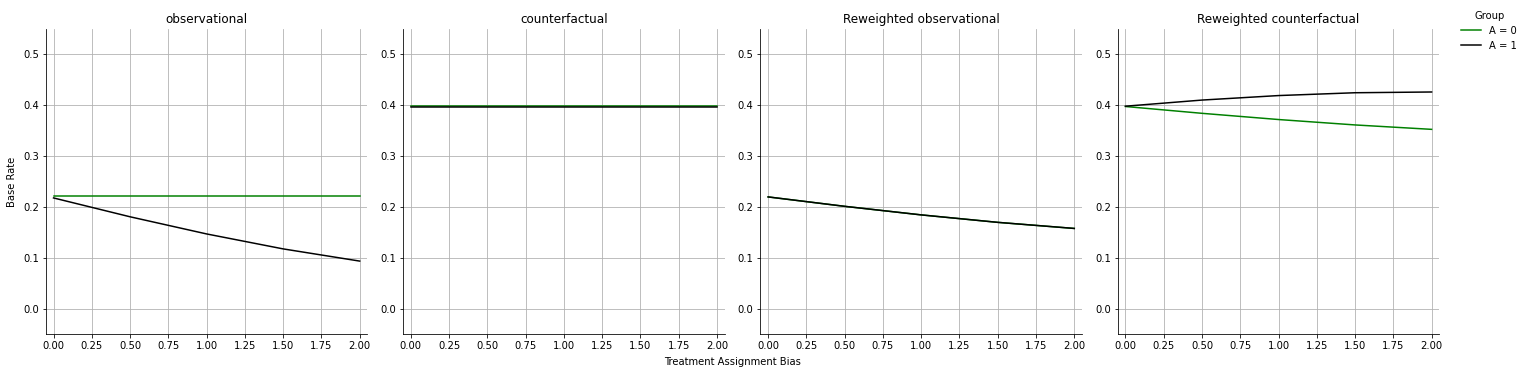

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from src.SyntheticData import SyntheticData
from src.SupervisedLearningModel import SupervisedLearningModel
from src.ReweighingAnalysisVisualizer import ReweighingAnalysisVisualizer
from src.MetricFrameGenerator import MetricFrameGenerator
from src.EqualizedOddsPostProcesser import EqualizedOddsPostProcesser
from src.EqualizedOddsPostProcessingAnalysis import EqualizedOddsPostProcessingAnalysis
from src.FairnessMetricVisualizer import FairnessMetricVisualizer

c, k = 0.1, 1.6
num_points = 100000

model_list = ['propensity', 'observational', 'counterfactual']

synthetic_data = SyntheticData(
    treatment_effect = c, 
    treatment_assignment_bias = k)
df, config = synthetic_data.generate(num_points = num_points)

for model_key in model_list:
    params = config.copy()
    clf = LogisticRegression(penalty = 'none')
    model = SupervisedLearningModel(model = clf, name = model_key)
    if model_key == 'propensity':
        params['target'] = params['treat']['name']
    else:
        params['target'] = params['outcome']['name']
    model.fit(df, params)
    train = df[params['features']['training']]
    if model_key == 'propensity':
        df[model_key] = clf.predict_proba(train)[:, 1:]
    else:
        df[model_key] = clf.predict_proba(train)[:, :1]

reweighing_analysis = ReweighingAnalysisVisualizer(config)
reweighing_analysis.visualize_base_rates(df, save = "")

<Figure size 720x360 with 0 Axes>

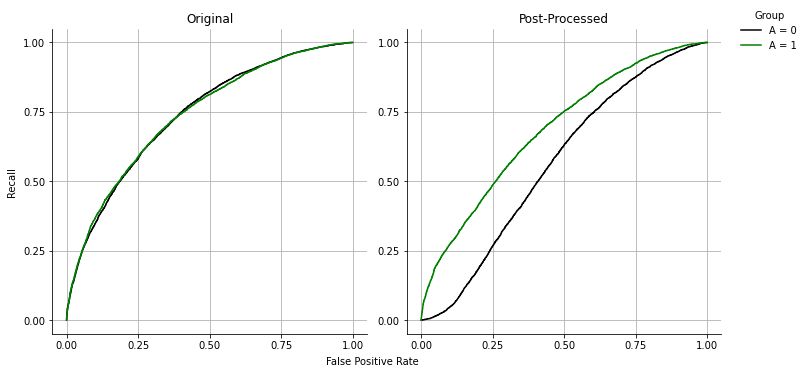

In [12]:
## Postprocess test and training datasets via equalized odds
metric_frame =  MetricFrameGenerator()
equalized_odds = EqualizedOddsPostProcesser(config)
observational = config['target']['observational']
sensitive = config['features']['sensitive']
_df, postprocessed = df[df.columns.difference(['treat', 'outcome'], sort=False)], {}
datasets = train_test_split(_df, test_size=0.3, random_state=0)
for key, raw_data in zip(['train', 'test'], datasets):
    data = raw_data.copy()
    metricframe = metric_frame.generate(data[observational], data['counterfactual'], data[sensitive])
    if key == 'train':
        mix_rates = equalized_odds.mix_rates(data, metricframe)
    probs = equalized_odds.post_process(data, metricframe, mix_rates)
    for sensitive_class, prob in probs.items():
        data.loc[data[sensitive] == sensitive_class, 'eo_fair_pred'] = prob
    postprocessed[key] = data

eo_analysis = EqualizedOddsPostProcessingAnalysis(config)
_eo = eo_analysis.visualize_roc(postprocessed['test'], save = '')

In [8]:
errors = eo_analysis.error_analysis(postprocessed['test'])
errors

,Group,Method,cGFPR,cGFNR,oGFPR,oGFNR
1,A = 1,Original,0.324847,0.512953,0.386767,0.585793
0,A = 0,Original,0.333597,0.502402,0.389717,0.565921
3,A = 1,Post-Processed,0.309219,0.579136,0.351574,0.627163
2,A = 0,Post-Processed,0.349289,0.632803,0.3508,0.623146


<Figure size 1440x360 with 0 Axes>

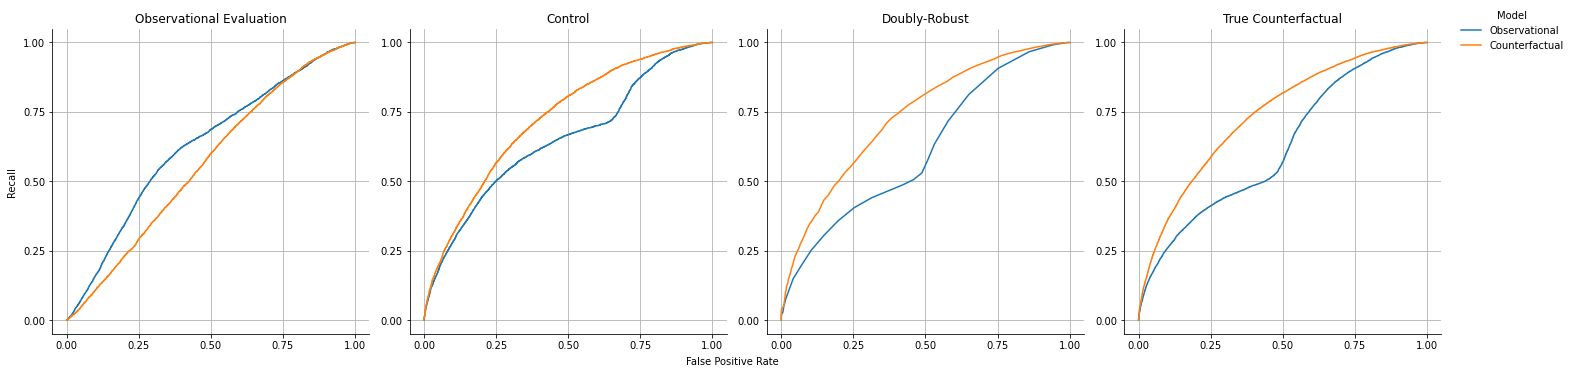

In [9]:
test_df = postprocessed['test']
roc = FairnessMetricVisualizer(metric = 'roc', parameters = config)
_roc = roc.visualize_metric(test_df, save = '')

<Figure size 1440x360 with 0 Axes>

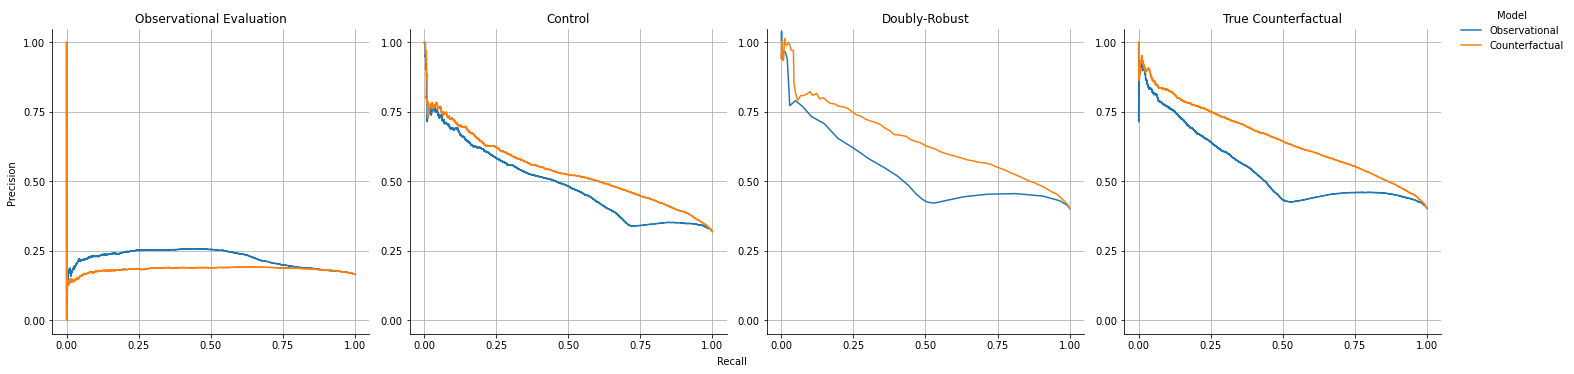

In [10]:
precision_recall = FairnessMetricVisualizer(metric = 'precision_recall', parameters = config)
_pr = precision_recall.visualize_metric(test_df, save = '')

<Figure size 1440x360 with 0 Axes>

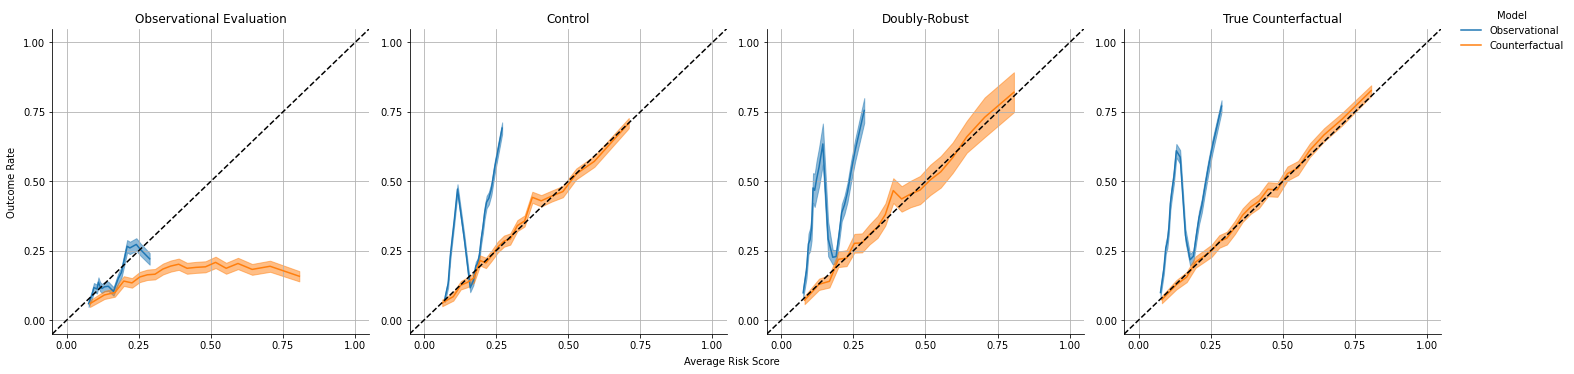

In [11]:
calibration = FairnessMetricVisualizer(metric = 'calibration', parameters = config)
_calibration = calibration.visualize_metric(test_df, save = '')

Although this notebook only validates re-runnability with Python 3.7, we believe that the source code can also be successfully executed in other environments with later versions of Python installed. From my local machine, we were able to successfully generate the same results shown in this notebook. Specifications of this executing environment are shown here:

<div><center>
<img src="./figures/rerunnable-01.png"></img>
</center></div>

Additionally, legacy R code used to produce the results of the study is fully containerized in a Docker image under build parameter `mode = reproduction`. We provide this to ensure that re-runnability holds for the original author's code. Results are provided below:

### Equalized Odds Postprocessing Results:
<div><center>
<img src="./figures/reproduction/post_processed/fig_roc_seed_000.png" width="500"></img>
</center></div>

### ROC Curve Results:
<div><center>
<img src="./figures/reproduction/roc/fig_seed_000.png" width="1200"></img>
</center></div>

### Precision-Recall Curve Results:
<div><center>
<img src="./figures/reproduction/precision_recall/fig_seed_000.png" width="1200"></img>
</center></div>

### Calibration Curve Results:
<div><center>
<img src="./figures/reproduction/calibration/fig_seed_000.png" width="1200"></img>
</center></div>


## References:

[1]: Benureau FCY, Rougier NP. Re-run, Repeat, Reproduce, Reuse, Replicate: Transforming Code into Scientific Contributions. Front Neuroinform. 2018 Jan 4;11:69. doi: 10.3389/fninf.2017.00069. PMID: 29354046; PMCID: PMC5758530.